In [3403]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os

In [3404]:
# Load the NetCDF file
file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/Strain_2D/example/Output/gpsgridder/NC_files/MYM_ITRF_gpsgridder_strain.nc'
ds = nc.Dataset(file_path)

# Load the earthquakedata
earthquake_file_path = '../data/mainshocks_Reasenberg.csv'
earthquake_data = pd.read_csv(earthquake_file_path)

# Check the available variables
print(ds.variables.keys())

# Extract the maximum shear strain rate
max_shear_strain = ds['max_shear'][:]
latitudes = ds['y'][:]
longitudes = ds['x'][:]

# Define the region of interest
min_lat_roi, max_lat_roi = 15, 28
min_lon_roi, max_lon_roi = 90, 98

dict_keys(['Ve', 'Vn', 'exx', 'eyy', 'exy', 'azimuth', 'rotation', 'I2', 'dilatation', 'max_shear', 'x', 'y'])


/Users/zuhair/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


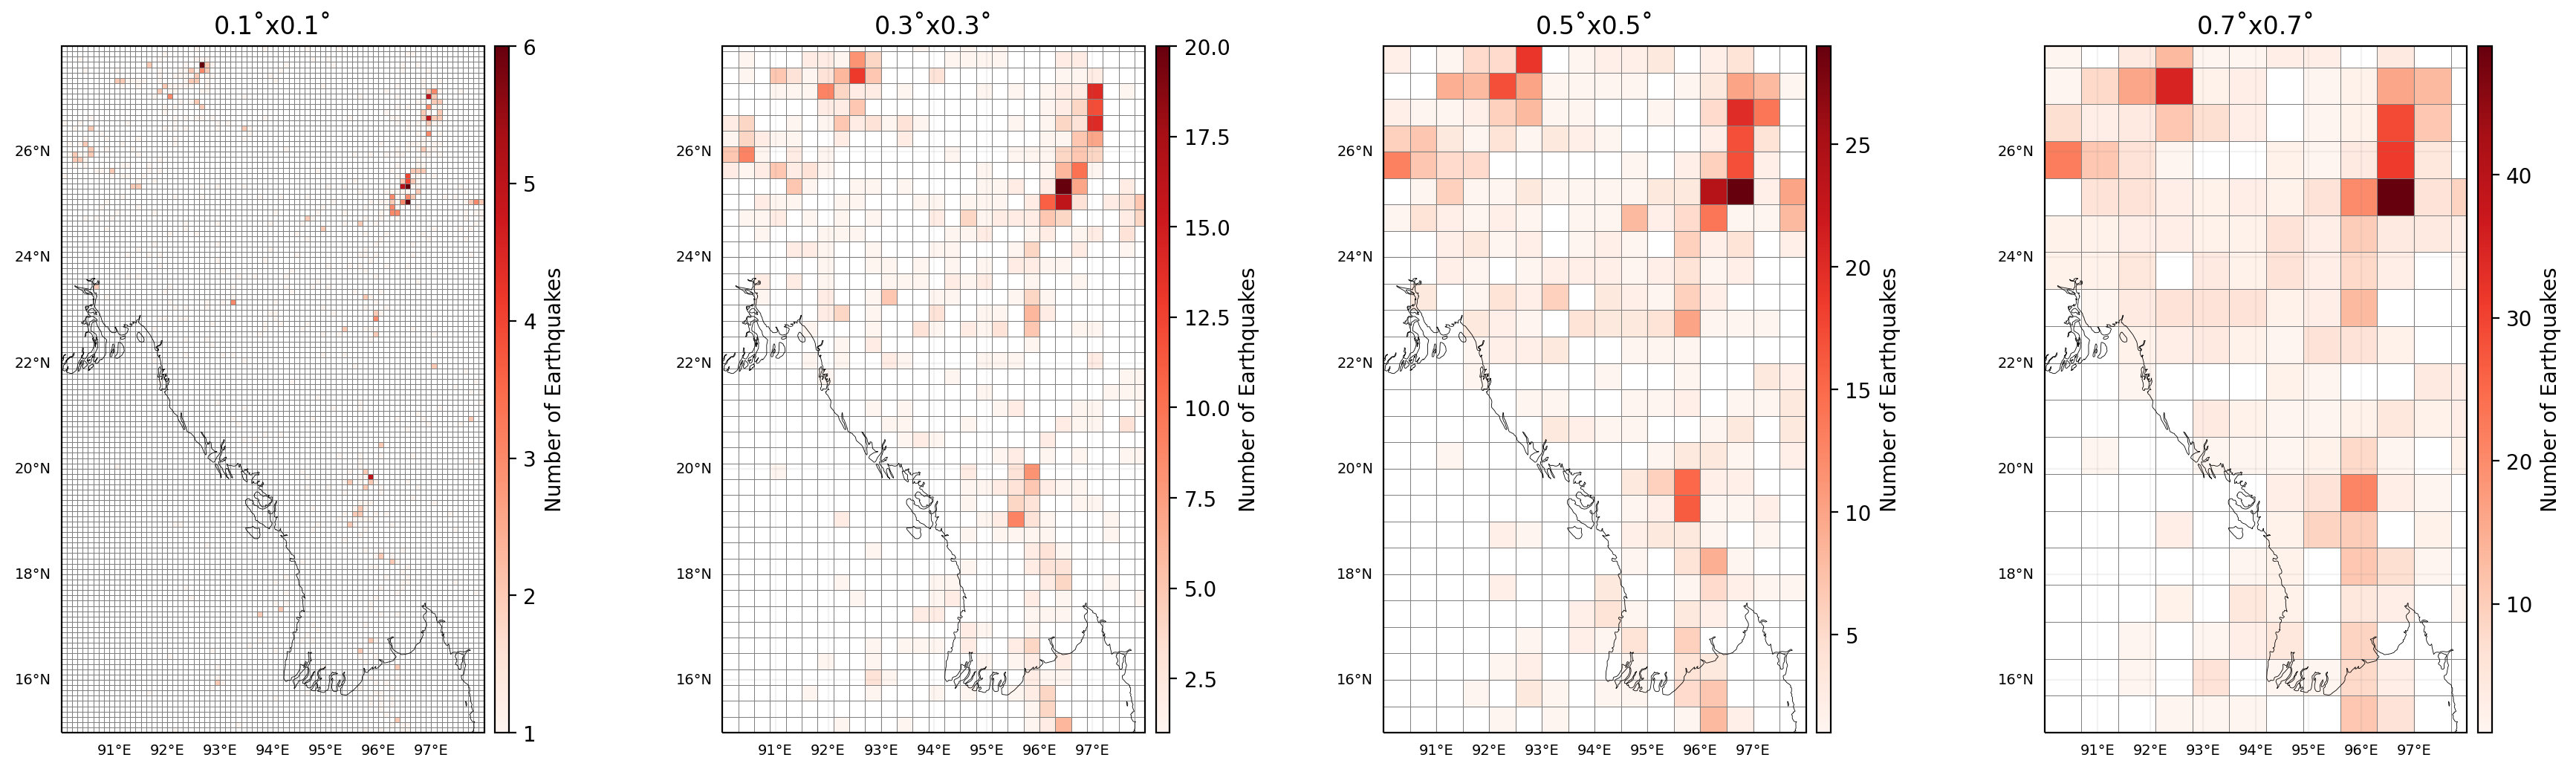

In [3405]:
# Function to plot the cell boundaries on a map using Cartopy
def plot_grid_cells(grid_size, ax):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['date'] >= '1904-01-01') &
        (earthquake_data['date'] <= '2022-12-31') &
        (earthquake_data['magnitude'] >= 4) &
        (earthquake_data['depth'] < 30)
    ]

    # Create an empty grid for earthquake counts
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            earthquake_count_grid[y_idx, x_idx] += 1

    # Mask the earthquake count grid to make cells with zero earthquakes white
    masked_earthquake_count_grid = ma.masked_where(earthquake_count_grid == 0, earthquake_count_grid)

    # Plot the cell boundaries on a map using Cartopy
    ax.coastlines(resolution='10m', color='black', linewidth=0.3)
    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.1, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 7, 'color': 'black', 'rotation': 0}
    gl.ylabel_style = {'size': 7, 'color': 'black'}

    # Plot the grid cells
    lon_grid_centered = (lon_bins[:-1] + lon_bins[1:]) / 2
    lat_grid_centered = (lat_bins[:-1] + lat_bins[1:]) / 2
    mesh_lon, mesh_lat = np.meshgrid(lon_grid_centered, lat_grid_centered)
    c = ax.pcolormesh(lon_bins, lat_bins, masked_earthquake_count_grid, cmap='Reds', alpha=1, edgecolor='gray', linewidth=0.2, transform=ccrs.PlateCarree())

    # Add colorbar
    cbar = plt.colorbar(c, ax=ax, orientation='vertical', pad=0.02, aspect=50)
    cbar.set_label('Number of Earthquakes')

    # Set extent and labels
    ax.set_extent([min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{grid_size}˚x{grid_size}˚')

# Define the grid sizes to test
grid_sizes = [0.1, 0.3, 0.5, 0.7]

# Create subplots for different grid sizes in a row
fig, axes = plt.subplots(1, 4, figsize=(22, 6), dpi=200, subplot_kw={'projection': ccrs.PlateCarree()})
for ax, grid_size in zip(axes, grid_sizes):
    plot_grid_cells(grid_size, ax)

# Save the figure to an 'output' folder
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'grid_cells_and_earthquakes_cartopy_comparison.png'), bbox_inches='tight')

# Display the plot
plt.show()

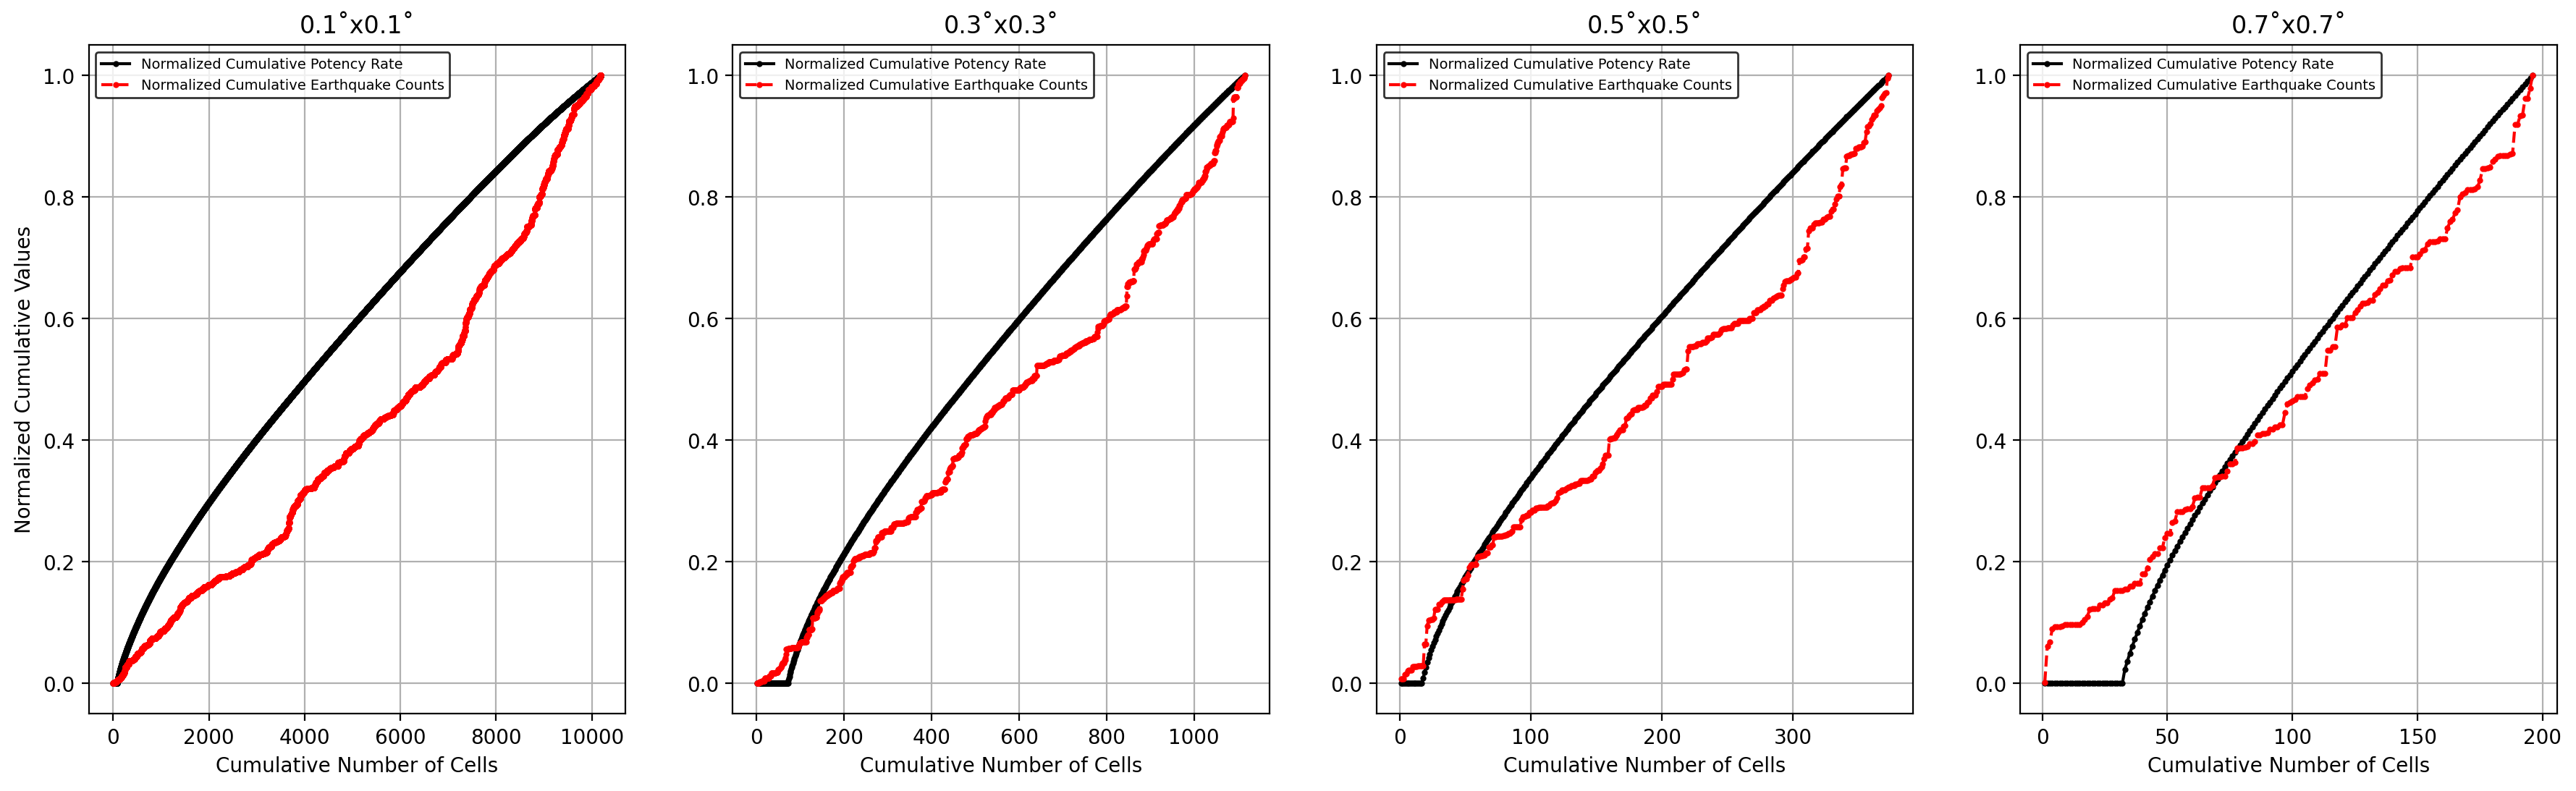

In [3406]:
# Function to perform the analysis for a given grid size
def analyze_grid_size(grid_size):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['date'] >= '1970-01-01') &
        (earthquake_data['date'] <= '2022-11-31') &
        (earthquake_data['magnitude'] > 3.8) &
        (earthquake_data['depth'] < 30)
    ]

    # Create an empty grid for earthquake counts
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            earthquake_count_grid[y_idx, x_idx] += 1

    # Flatten the earthquake count grid
    flattened_earthquake_counts = earthquake_count_grid.flatten()

    # Ensure the lengths of the arrays match
    min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
    sorted_indices = sorted_indices[:min_length]
    sorted_strain_rates = sorted_strain_rates[:min_length]
    flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

    # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
    valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]

    # Sort the flattened earthquake counts to match the strain rate sorting
    sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
    sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
    grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

    # Calculate cumulative geodetic potency rate and normalize
    cumulative_potency_rate = np.cumsum(sorted_strain_rates * grid_cell_area)

    # Normalize the cumulative curves, ensuring no division by zero
    normalized_cumulative_potency_rate = cumulative_potency_rate / cumulative_potency_rate[-1] if cumulative_potency_rate[-1] != 0 else np.zeros_like(cumulative_potency_rate)

    # Calculate cumulative earthquake counts and normalize
    cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
    normalized_cumulative_earthquake_counts = cumulative_earthquake_counts / cumulative_earthquake_counts[-1] if cumulative_earthquake_counts[-1] != 0 else np.zeros_like(cumulative_earthquake_counts)

    return normalized_cumulative_potency_rate, normalized_cumulative_earthquake_counts

# Define the grid sizes to test
# grid_sizes = [0.1, 0.3, 0.5]

# Create subplots for different grid sizes in a row
fig, axes = plt.subplots(1, 4, figsize=(22, 6), dpi=200)
for i, (ax, grid_size) in enumerate(zip(axes, grid_sizes)):
    norm_potency_rate, norm_earthquake_counts = analyze_grid_size(grid_size)
    
    # Plot the normalized cumulative curves with enhanced visibility
    ax.plot(range(1, len(norm_potency_rate) + 1), norm_potency_rate, label='Normalized Cumulative Potency Rate', marker='o', color='k', markersize = 2)
    ax.plot(range(1, len(norm_earthquake_counts) + 1), norm_earthquake_counts, label='Normalized Cumulative Earthquake Counts', linestyle='--', marker='o', color='r', markersize = 2)
    ax.set_xlabel('Cumulative Number of Cells')
    if i == 0:
        ax.set_ylabel('Normalized Cumulative Values')
    ax.set_title(f'{grid_size}˚x{grid_size}˚')
    ax.legend(fontsize='7', loc='upper left', frameon=True, facecolor='white', edgecolor='k')
    ax.grid(True)

# Save the figure to an 'output' folder
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'correlation_test_comparison.png'), bbox_inches='tight')

# Display the plot
plt.show()

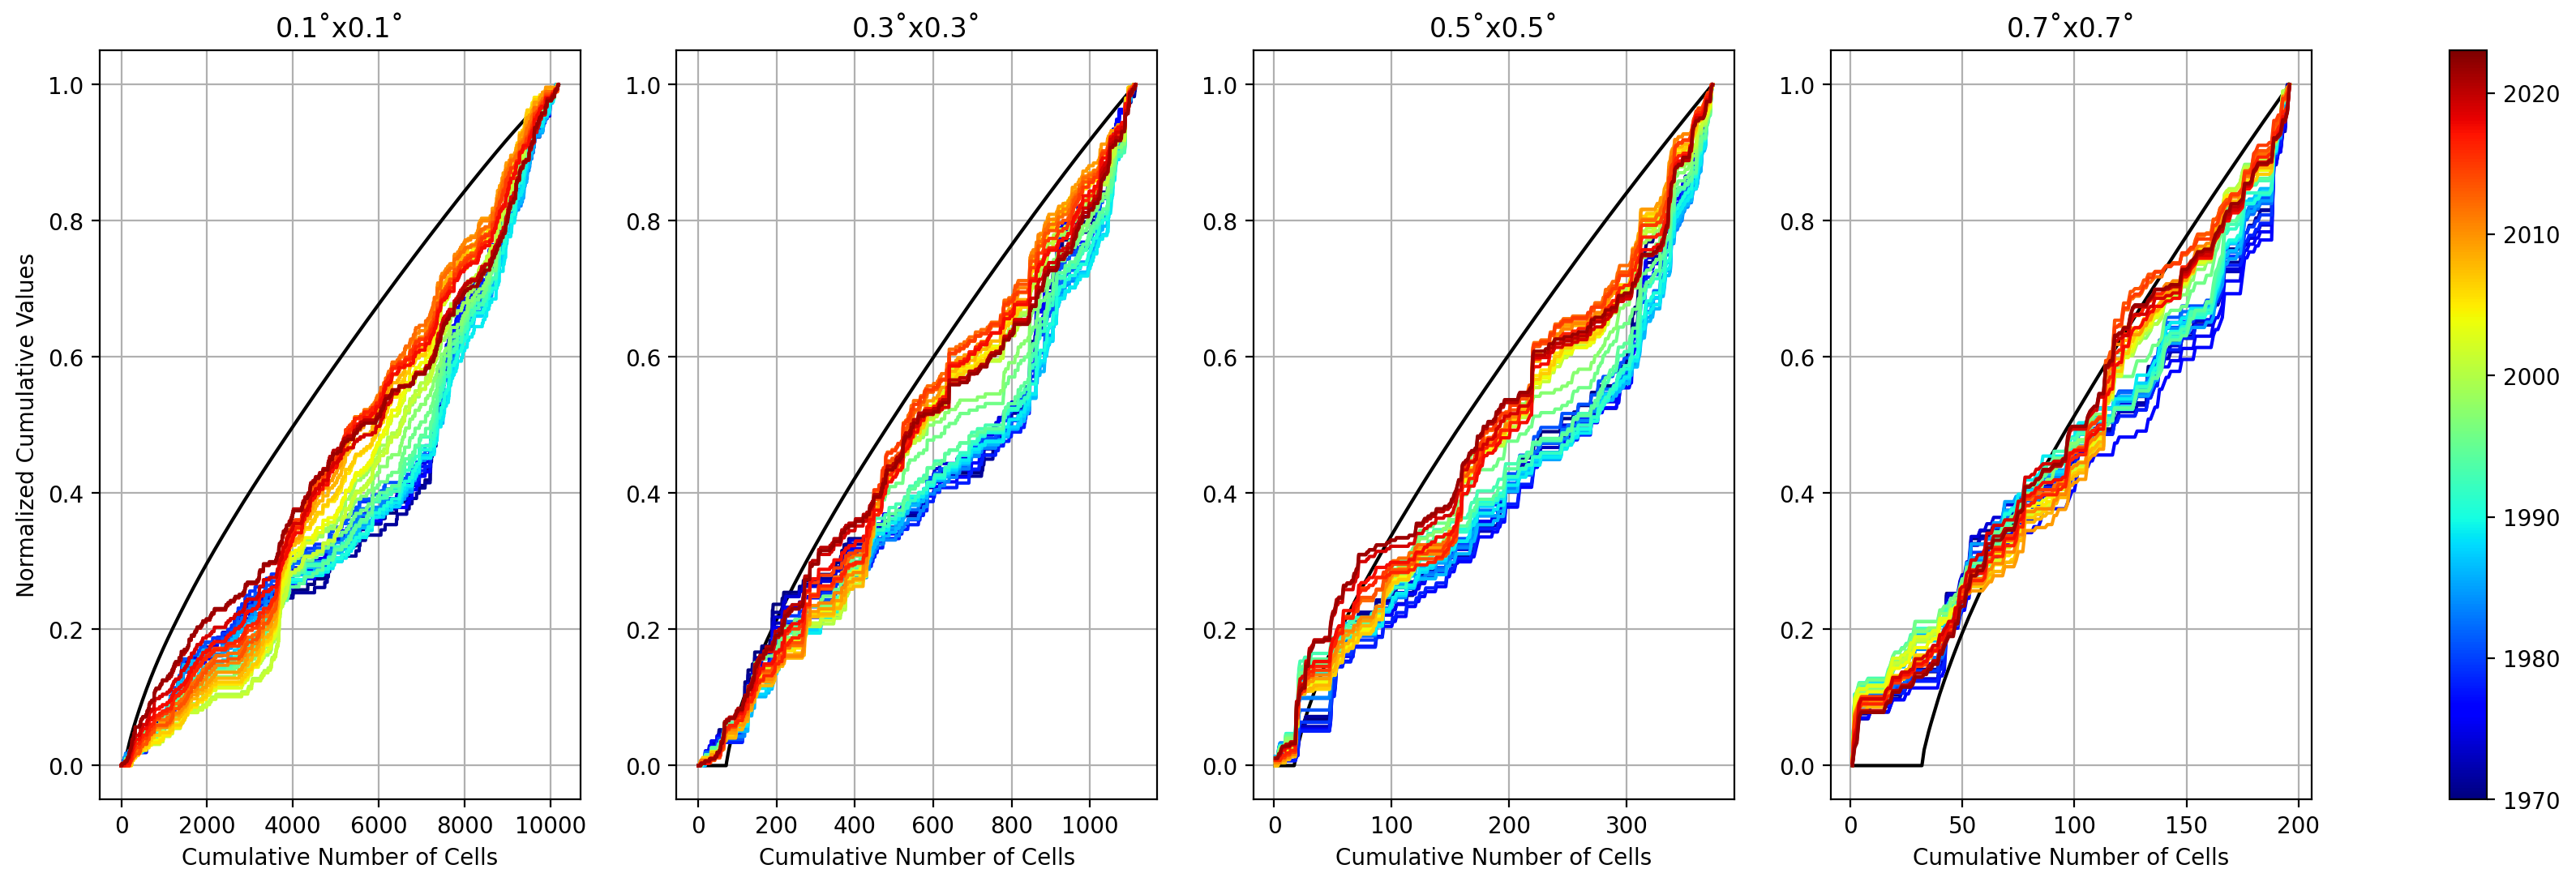

In [3407]:
# Function to calculate and plot cumulative potency and earthquake counts
def plot_cumulative_potency_and_earthquake_counts(grid_size, ax, first_col):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Filter the earthquake data for the region of interest, time period, completeness magnitude, and depth
    filtered_earthquake_locations_roi = earthquake_data[
        (earthquake_data['latitude'] >= min_lat_roi) &
        (earthquake_data['latitude'] <= max_lat_roi) &
        (earthquake_data['longitude'] >= min_lon_roi) &
        (earthquake_data['longitude'] <= max_lon_roi) &
        (earthquake_data['date'] >= '1970-01-01') &
        (earthquake_data['date'] <= '2022-11-31') &
        (earthquake_data['magnitude'] > 3.8) &
        (earthquake_data['depth'] < 30)
    ]

    # Create an empty grid for earthquake counts
    earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))

    # Digitize the filtered earthquake locations into the grid
    x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
    y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

    # Increment the earthquake count for each grid cell
    for x_idx, y_idx in zip(x_indices, y_indices):
        if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
            earthquake_count_grid[y_idx, x_idx] += 1

    # Flatten the earthquake count grid
    flattened_earthquake_counts = earthquake_count_grid.flatten()

    # Ensure the lengths of the arrays match
    min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
    sorted_indices = sorted_indices[:min_length]
    sorted_strain_rates = sorted_strain_rates[:min_length]
    flattened_earthquake_counts = flattened_earthquake_counts[:min_length]

    # Ensure sorted_indices contains valid indices for flattened_earthquake_counts
    valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]
    sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
    sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
    grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

    # Calculate cumulative geodetic potency rate and normalize
    cumulative_potency_rate = np.cumsum(sorted_strain_rates * grid_cell_area)
    normalized_cumulative_potency_rate = cumulative_potency_rate / cumulative_potency_rate[-1] if cumulative_potency_rate[-1] != 0 else np.zeros_like(cumulative_potency_rate)

    # Calculate cumulative earthquake counts and normalize
    cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts * grid_cell_area)
    normalized_cumulative_earthquake_counts = cumulative_earthquake_counts / cumulative_earthquake_counts[-1] if cumulative_earthquake_counts[-1] != 0 else np.zeros_like(cumulative_earthquake_counts)

    # Define the moving window parameters
    start_year = 1970
    end_year = 2023
    window_size = 15  # 20-year window
    step_size = 1  # 1-year step

    # Prepare to store cumulative earthquake counts for each window
    cumulative_counts_per_window = []

    # Calculate cumulative earthquake counts for each window
    for start in range(start_year, end_year - window_size + 1, step_size):
        end = start + window_size
        window_data = filtered_earthquake_locations_roi[
            (filtered_earthquake_locations_roi['date'] >= f'{start}-01-01') &
            (filtered_earthquake_locations_roi['date'] < f'{end}-01-01')
        ]

        # Digitize the earthquake locations for the current window
        earthquake_count_grid_window = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
        x_indices = np.digitize(window_data['longitude'], lon_bins) - 1
        y_indices = np.digitize(window_data['latitude'], lat_bins) - 1

        for x_idx, y_idx in zip(x_indices, y_indices):
            if 0 <= x_idx < earthquake_count_grid_window.shape[1] and 0 <= y_idx < earthquake_count_grid_window.shape[0]:
                earthquake_count_grid_window[y_idx, x_idx] += 1

        flattened_counts = earthquake_count_grid_window.flatten()
        sorted_counts = flattened_counts[valid_sorted_indices[:len(flattened_counts)]]
        cumulative_counts = np.cumsum(sorted_counts)
        normalized_cumulative_counts = cumulative_counts / cumulative_counts[-1] if cumulative_counts[-1] != 0 else cumulative_counts
        cumulative_counts_per_window.append((start + window_size // 2, normalized_cumulative_counts))

    # Plot the normalized cumulative potency rate in black
    ax.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, color='black', label='Cumulative Potency Rate')

    # Define the color map
    cmap = plt.get_cmap('jet')
    norm = mcolors.Normalize(vmin=start_year + window_size // 2, vmax=end_year - window_size // 2)

    # Plot the normalized cumulative earthquake counts for each window
    for midyear, counts in cumulative_counts_per_window:
        ax.plot(range(1, len(counts) + 1), counts, color=cmap(norm(midyear)))

    # Customize plot
    ax.set_xlabel('Cumulative Number of Cells')
    if first_col:
        ax.set_ylabel('Normalized Cumulative Values')
    ax.set_title(f'{grid_size}˚x{grid_size}˚')
    # ax.legend()
    ax.grid(True)

# Create subplots for different grid sizes
fig, axes = plt.subplots(1, 4, figsize=(22, 6), dpi=200)
grid_sizes = [0.1, 0.3, 0.5, 0.7]
for i, (ax, grid_size) in enumerate(zip(axes, grid_sizes)):
    plot_cumulative_potency_and_earthquake_counts(grid_size, ax, first_col=(i == 0))

# Add a single colorbar on the far right
sm = plt.cm.ScalarMappable(cmap='jet', norm=mcolors.Normalize(vmin=1970, vmax=2023))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical')
# cbar.set_label('Midyear of Moving Window')

# Save the figure to an 'output' folder
# output_dir = 'output'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# plt.savefig(os.path.join(output_dir, 'cumulative_potency_earthquake_counts_comparison.png'), bbox_inches='tight')

# Display the plot
plt.show()

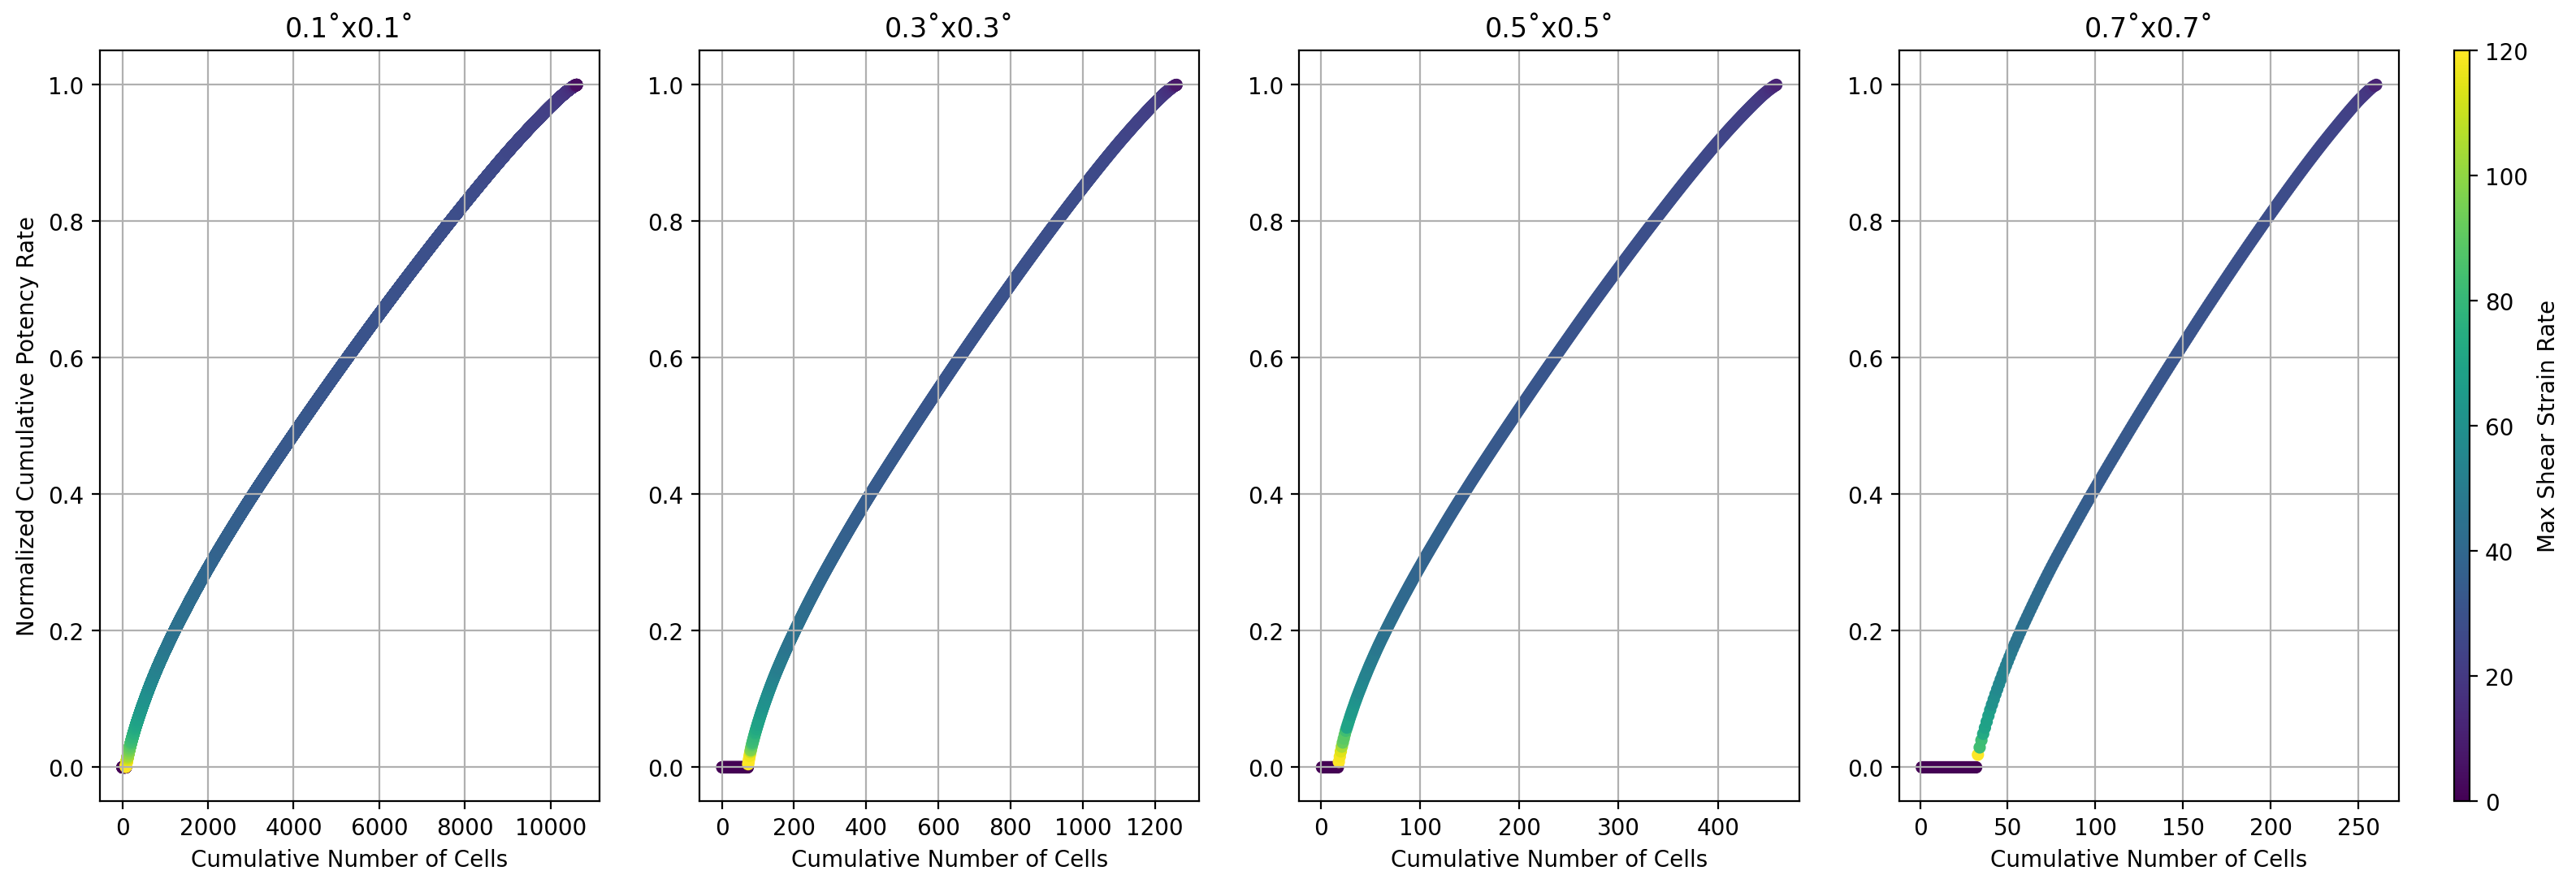

In [3408]:
# Define the range of strain rates you are interested in
vmin = 0  # Minimum strain rate value for color coding
vmax = 120  # Maximum strain rate value for color coding

# Function to calculate and plot cumulative potency rate with color-coding by strain rates
def plot_color_coded_cumulative_potency(grid_size, ax, is_first_col):
    # Define the grid parameters
    lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
    lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)

    # Create a meshgrid for the region of interest
    lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

    # Interpolate the strain rates onto the grid
    points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
    values = max_shear_strain.flatten()
    interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

    # Flatten the interpolated strain rates
    flattened_strain_rates = interpolated_strain_rates.flatten()
    sorted_indices = np.argsort(flattened_strain_rates)[::-1]
    sorted_strain_rates = flattened_strain_rates[sorted_indices]

    # Handle NaN values in sorted_strain_rates
    sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

    # Calculate the area of each grid cell (in km², assuming 1 degree ~ 111.32 km)
    grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)

    # Calculate cumulative geodetic potency rate and normalize
    cumulative_potency_rate = np.cumsum(sorted_strain_rates * grid_cell_area)
    normalized_cumulative_potency_rate = cumulative_potency_rate / cumulative_potency_rate[-1] if cumulative_potency_rate[-1] != 0 else np.zeros_like(cumulative_potency_rate)

    # Plot the color-coded cumulative potency rate
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sc = ax.scatter(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate,
                    c=sorted_strain_rates, cmap=cmap, norm=norm, marker='o', s=20, label='Cumulative Potency Rate')

    # Customize plot
    ax.set_xlabel('Cumulative Number of Cells')
    if is_first_col:
        ax.set_ylabel('Normalized Cumulative Potency Rate')
    ax.set_title(f'{grid_size}˚x{grid_size}˚')
    ax.grid(True)
    return sc

# Create subplots for different grid sizes
fig, axes = plt.subplots(1, 4, figsize=(22, 6), dpi=200)
grid_sizes = [0.1, 0.3, 0.5, 0.7]
for i, (ax, grid_size) in enumerate(zip(axes, grid_sizes)):
    sc = plot_color_coded_cumulative_potency(grid_size, ax, is_first_col=(i == 0))

# Add a single colorbar for all plots
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('Max Shear Strain Rate')

# Save the figure to an 'output' folder
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'color_coded_cumulative_potency_rate_comparison.png'), bbox_inches='tight')

# Display the plot
plt.show()